In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix



from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb

In [60]:
df = pd.read_csv("food_dataset.csv")
df=df.dropna()
print(df.shape)



(31325, 16)


In [61]:
df = df.drop_duplicates()


In [ ]:

suspicious_cols = [col for col in df.columns if 'is_suspicious' in col]
df.drop(columns=suspicious_cols, inplace=True, errors='ignore')

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv("food_dataset_cleaned.csv", index=False)
print("Preprocessing complete. Cleaned dataset saved as 'food_dataset_cleaned.csv'.")
print("Cleaned Dataset shape:", df.shape)


Preprocessing complete. Cleaned dataset saved as 'food_dataset_cleaned.csv'.
Cleaned Dataset shape: (31260, 16)


In [63]:
numeric_cols = df.select_dtypes(include='number').columns

zero_cols = []
for col in numeric_cols:
    if (df[col] == 0).any():  
        df[f'{col}_is_zero'] = (df[col] == 0)  
        zero_cols.append(f'{col}_is_zero')    

print("Columns with zero flags:", zero_cols)

num_cols = df.select_dtypes(include=['int64','float64']).columns
print("Numeric columns:", list(num_cols))

zero_counts = (df[num_cols] == 0).sum()
print("\nZero counts in all numeric columns:\n")
print(zero_counts)

cols_with_zeros = zero_counts[zero_counts > 0].index.tolist()
print("\nColumns that contain zeros:", cols_with_zeros)

if "protein" in df.columns:
    protein_zero_index = df.index[df["protein"] == 0].tolist()
    print("\nIndex where protein = 0:", protein_zero_index)

if zero_cols:
    print(df[zero_cols].head(20))
    print(df[zero_cols].columns, df[zero_cols].shape)  
else:
    print("No numeric columns with zeros found.")


Columns with zero flags: ['Protein_is_zero', 'Fat_is_zero', 'Carbs_is_zero', 'Sugar_is_zero', 'Fiber_is_zero', 'Sodium_is_zero', 'Cholesterol_is_zero', 'Glycemic_Index_is_zero']
Numeric columns: ['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size']

Zero counts in all numeric columns:

Calories             0
Protein             16
Fat                  9
Carbs             1019
Sugar             1011
Fiber             2479
Sodium             313
Cholesterol       3624
Glycemic_Index     982
Water_Content        0
Serving_Size         0
dtype: int64

Columns that contain zeros: ['Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index']
    Protein_is_zero  Fat_is_zero  Carbs_is_zero  Sugar_is_zero  Fiber_is_zero  \
0             False        False          False          False          False   
1             False        False          False          False          False   
2     

In [ ]:

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
print(df.info())
print("\nNumeric summary statistics:")
print(df.describe())


print("\nMissing values per column:")
print(df.isna().sum())
print("\nMissing values percentage per column:")
print((df.isna().sum()/len(df)*100).round(2))


Shape: (31260, 24)

Columns: ['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size', 'Meal_Type', 'Preparation_Method', 'Is_Vegan', 'Is_Gluten_Free', 'Food_Name', 'Protein_is_zero', 'Fat_is_zero', 'Carbs_is_zero', 'Sugar_is_zero', 'Fiber_is_zero', 'Sodium_is_zero', 'Cholesterol_is_zero', 'Glycemic_Index_is_zero']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31260 entries, 0 to 31259
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Calories                31260 non-null  float64
 1   Protein                 31260 non-null  float64
 2   Fat                     31260 non-null  float64
 3   Carbs                   31260 non-null  float64
 4   Sugar                   31260 non-null  float64
 5   Fiber                   31260 non-null  float64
 6   Sodium                  31260 non-null  float64
 7   Cholester

In [65]:
numeric_cols = df.select_dtypes(include='number').columns
zero_cols = []
for col in numeric_cols:
    if (df[col] == 0).any():
        df[f'{col}_is_zero'] = (df[col] == 0)
        zero_cols.append(f'{col}_is_zero')

if zero_cols:
    print("\nColumns with zeros:", zero_cols)
    print("Zero counts per flagged column:")
    print(df[zero_cols].sum())



Columns with zeros: ['Protein_is_zero', 'Fat_is_zero', 'Carbs_is_zero', 'Sugar_is_zero', 'Fiber_is_zero', 'Sodium_is_zero', 'Cholesterol_is_zero', 'Glycemic_Index_is_zero']
Zero counts per flagged column:
Protein_is_zero             16
Fat_is_zero                  9
Carbs_is_zero             1019
Sugar_is_zero             1011
Fiber_is_zero             2479
Sodium_is_zero             313
Cholesterol_is_zero       3624
Glycemic_Index_is_zero     982
dtype: int64


In [66]:
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\nColumn: {col}")
    print("Value counts:")
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True).round(2))



Column: Meal_Type
Value counts:
Meal_Type
snack        7892
breakfast    7840
dinner       7770
lunch        7758
Name: count, dtype: int64
Meal_Type
snack        0.25
breakfast    0.25
dinner       0.25
lunch        0.25
Name: proportion, dtype: float64

Column: Preparation_Method
Value counts:
Preparation_Method
baked      7940
raw        7837
grilled    7833
fried      7650
Name: count, dtype: int64
Preparation_Method
baked      0.25
raw        0.25
grilled    0.25
fried      0.24
Name: proportion, dtype: float64

Column: Food_Name
Value counts:
Food_Name
Pizza        5900
Burger       4923
Donut        4454
Pasta        3959
Sushi        3450
Ice Cream    2954
Steak        1981
Apple        1471
Banana       1184
Salad         984
Name: count, dtype: int64
Food_Name
Pizza        0.19
Burger       0.16
Donut        0.14
Pasta        0.13
Sushi        0.11
Ice Cream    0.09
Steak        0.06
Apple        0.05
Banana       0.04
Salad        0.03
Name: proportion, dtype: float64


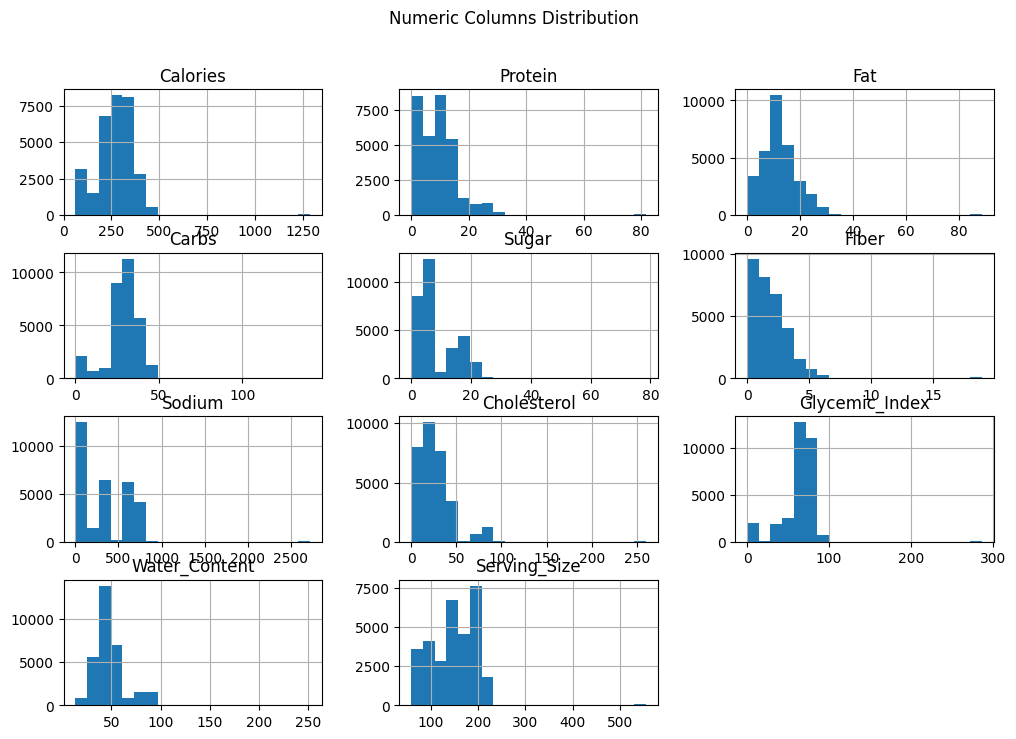

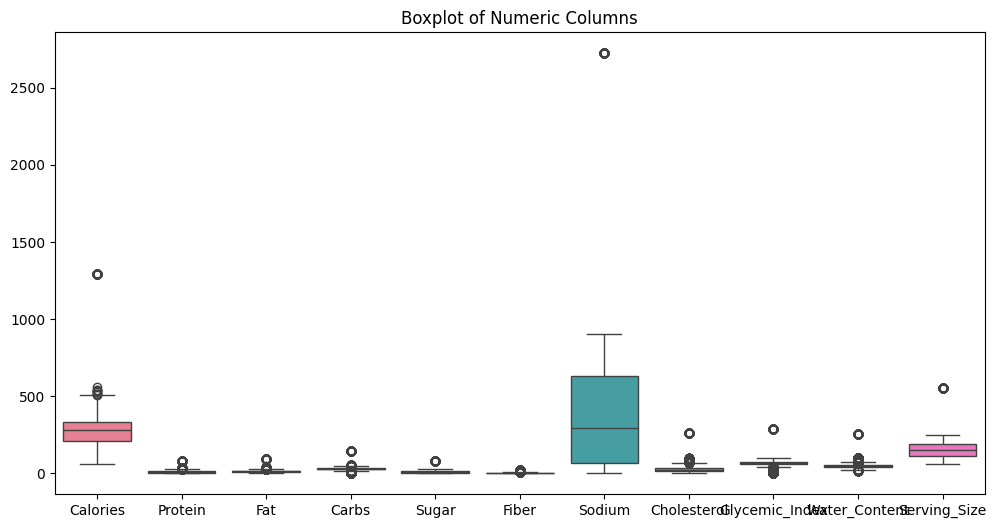

In [83]:

df[numeric_cols].hist(figsize=(12,8), bins=20)
plt.suptitle("Numeric Columns Distribution")
plt.show()


plt.figure(figsize=(12,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Numeric Columns")
plt.show()


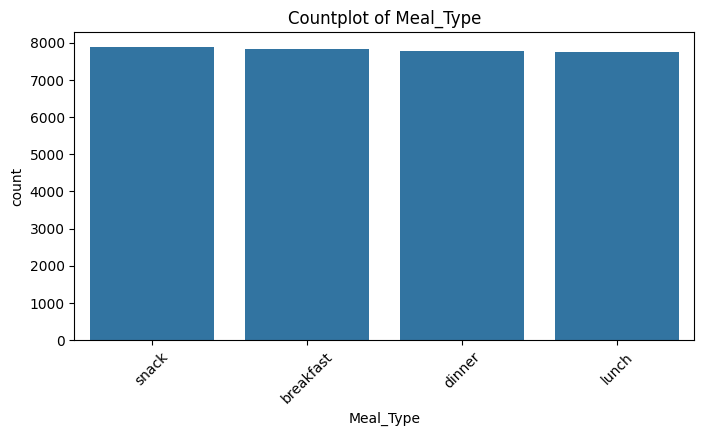

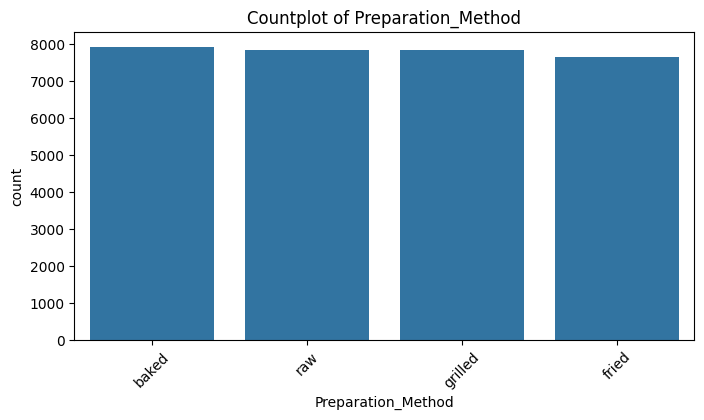

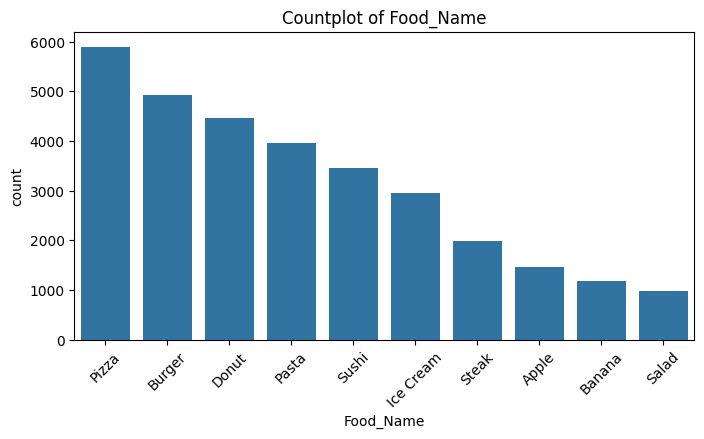

In [68]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
    plt.show()



Correlation matrix:
                Calories   Protein       Fat     Carbs     Sugar     Fiber  \
Calories        1.000000  0.784635  0.812625  0.286410 -0.115676  0.024396   
Protein         0.784635  1.000000  0.744492  0.011047 -0.257308  0.105724   
Fat             0.812625  0.744492  1.000000  0.069413  0.050042 -0.036315   
Carbs           0.286410  0.011047  0.069413  1.000000  0.301198  0.362689   
Sugar          -0.115676 -0.257308  0.050042  0.301198  1.000000  0.210036   
Fiber           0.024396  0.105724 -0.036315  0.362689  0.210036  1.000000   
Sodium          0.551709  0.532459  0.517990  0.388061  0.006091  0.232376   
Cholesterol     0.722388  0.810652  0.831387 -0.118303  0.075092 -0.067733   
Glycemic_Index  0.274372  0.036499  0.143018  0.826922  0.343673  0.313639   
Water_Content  -0.078939  0.160067 -0.014499 -0.009857  0.302740  0.640317   
Serving_Size    0.621672  0.778001  0.464306  0.184503 -0.301470  0.302753   

                  Sodium  Cholesterol  Gly

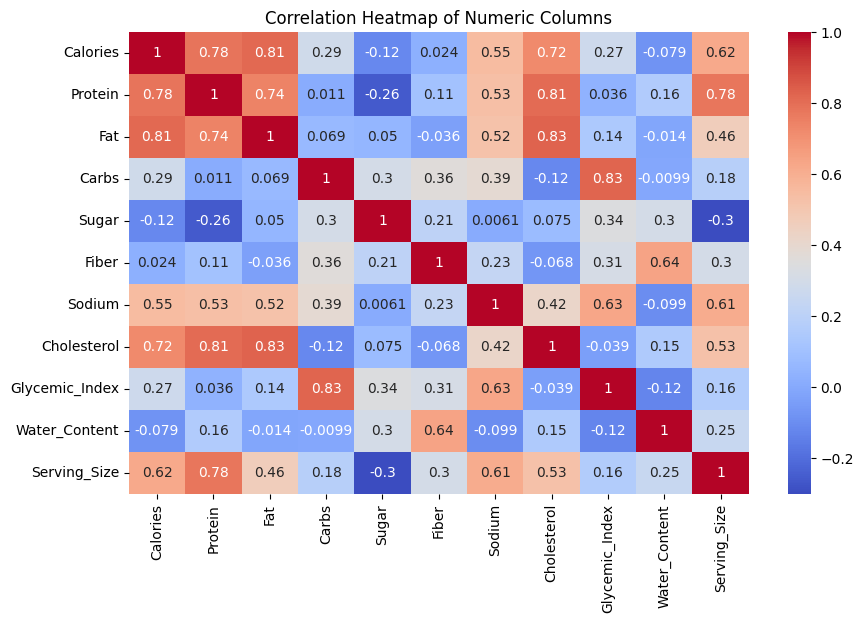

In [69]:
corr = df[numeric_cols].corr()
print("\nCorrelation matrix:")
print(corr)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()


In [70]:
print("\nEDA Complete.")



EDA Complete.


# MODELLING #

In [71]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb


In [72]:
cal_limit = 500
fat_limit = 20
sodium_limit = 1200
fiber_limit = 5

def health_label(row):
    if (row['Calories'] > cal_limit or
        row['Fat'] > fat_limit or
        row['Sodium'] > sodium_limit or
        row['Fiber'] < fiber_limit):
        return "unhealthy"
    else:
        return "healthy"

df['Health'] = df.apply(health_label, axis=1)
print("Health label counts:\n", df['Health'].value_counts())


Health label counts:
 Health
unhealthy    30479
healthy        781
Name: count, dtype: int64


In [74]:
X = df.drop('Health', axis=1)
y = df['Health']

le = LabelEncoder()
y = le.fit_transform(y)

X = pd.get_dummies(X, drop_first=True)


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [77]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}


In [78]:
results = []

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    results.append({
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
    })
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix - {name}:\n", cm)


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Confusion Matrix - Logistic Regression:
 [[ 146   10]
 [   9 6087]]

Confusion Matrix - Decision Tree:
 [[ 156    0]
 [   0 6096]]

Confusion Matrix - Random Forest:
 [[ 155    1]
 [   0 6096]]

Confusion Matrix - K-Nearest Neighbors:
 [[  62   94]
 [  54 6042]]

Confusion Matrix - Support Vector Machine:
 [[   0  156]
 [   0 6096]]


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:43:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Confusion Matrix - XGBoost:
 [[ 156    0]
 [   0 6096]]

Confusion Matrix - Gradient Boosting:
 [[ 156    0]
 [   0 6096]]


In [82]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nClassifier Comparison:\n")
print(results_df)



Classifier Comparison:

               Classifier  Accuracy  Precision    Recall  F1-Score
1           Decision Tree  1.000000   1.000000  1.000000  1.000000
5                 XGBoost  1.000000   1.000000  1.000000  1.000000
6       Gradient Boosting  1.000000   1.000000  1.000000  1.000000
2           Random Forest  0.999840   0.999840  0.999840  0.999840
0     Logistic Regression  0.996961   0.996952  0.996961  0.996956
3     K-Nearest Neighbors  0.976328   0.973447  0.976328  0.974626
4  Support Vector Machine  0.975048   0.950719  0.975048  0.962730
